In [5]:
import os
import pandas as pd
import numpy as np
from scipy import stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
searched_format = 'csv'
for file in os.listdir(os.getcwd()):
    if searched_format in file:
        PATH = os.path.abspath(file)

order_id,delivery_time,district,experiment_group



In [5]:
experiment_df = pd.read_csv(PATH)
experiment_df

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


## Убедимся, что всё считалось правильно: посмотрим на столбцы, типы данных, размерность, наличие пропущенных значений.

In [6]:
experiment_df.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [7]:
experiment_df.shape

(20196, 4)

In [8]:
experiment_df.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [9]:
experiment_df.describe()

,order_id,delivery_time
count,20196.000000,20196.000000
mean,11103.503565,42.054169
std,5835.424404,10.382196
min,1000.000000,10.000000
25%,6048.750000,35.000000
50%,11109.500000,42.000000
75%,16158.250000,49.000000
max,21207.000000,83.000000


In [10]:
experiment_df.nunique()

order_id            20196
delivery_time          72
district                3
experiment_group        2
dtype: int64

## Построим графики распределения тестовой и контрольной групп:

In [11]:
experiment_df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


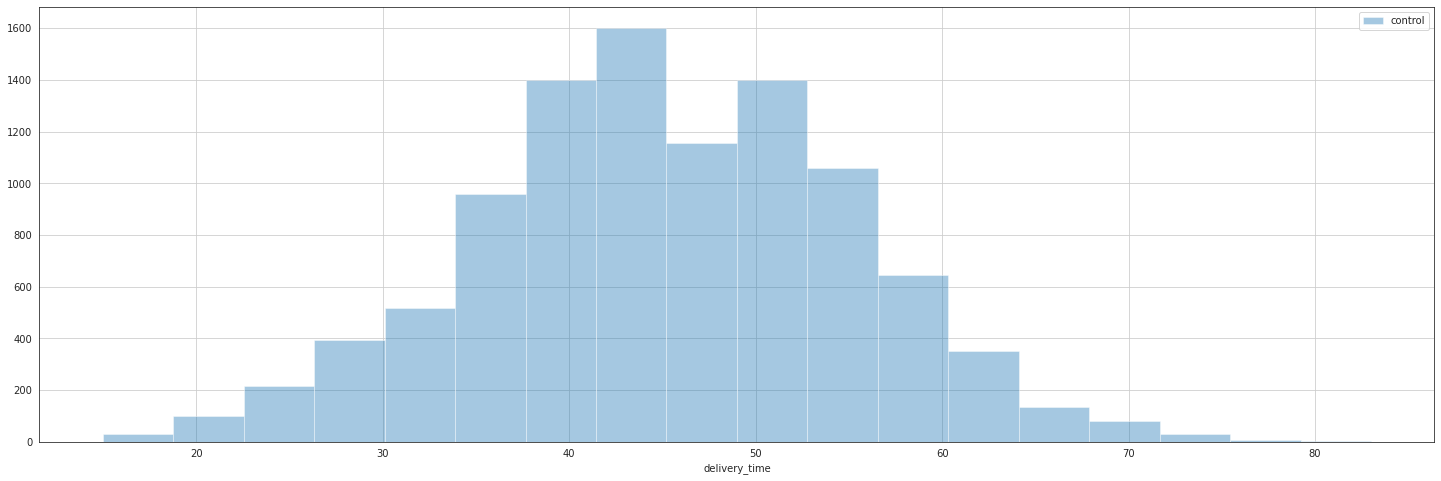

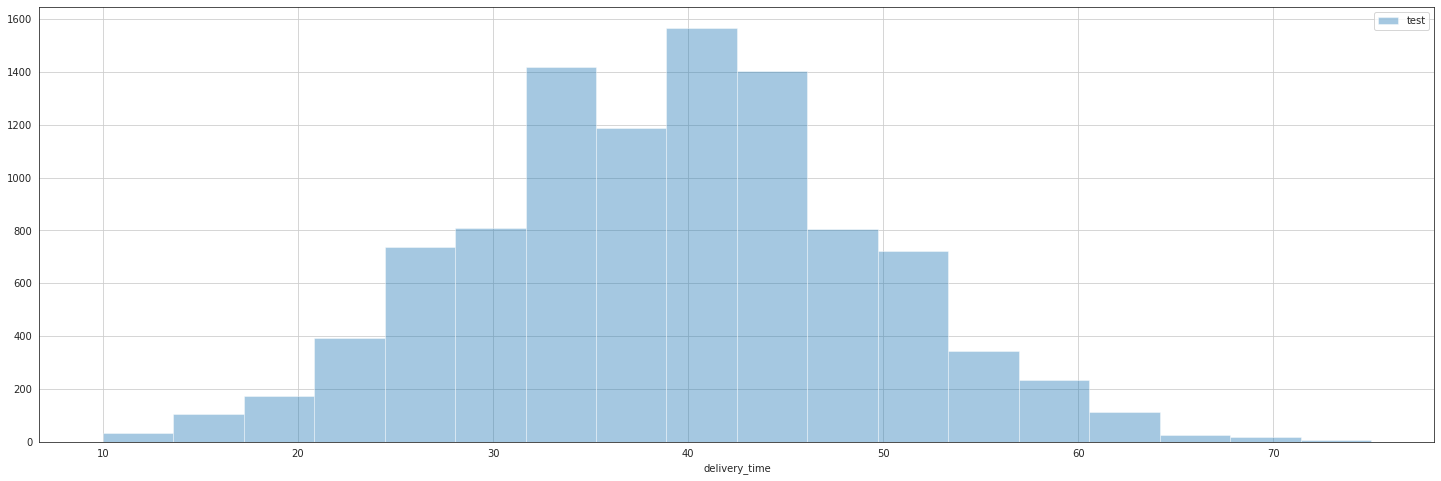

In [26]:
for group in experiment_df.experiment_group.unique():
    plt.figure(figsize = (25,8))
    sns.set_style("white")
    sns.distplot(experiment_df.query('experiment_group == @group').delivery_time, bins=18, kde=False, label=group)
    plt.legend()
    plt.grid()
plt.show()

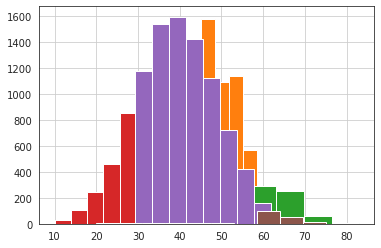

In [29]:
experiment_df.query('experiment_group == "test"').groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

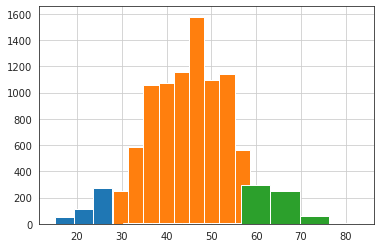

In [30]:
experiment_df.query('experiment_group == "control"').groupby('district').delivery_time.hist()

## Посчитаем количество наблюдений в тестовой и контрольной группе. 
### Определим, на сколько по модулю отличается количество наблюдений в тесте и контроле?

In [43]:
experiment_df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [37]:
measurment_number_df = experiment_df.groupby('experiment_group', as_index=False).agg({'delivery_time': 'count'}).rename(columns={'delivery_time': 'mes_number'})
measurment_number_df

,experiment_group,mes_number
0,control,10092
1,test,10104


In [55]:
measurment_number_df.query("experiment_group == 'test'").mes_number.values[0] - measurment_number_df.query("experiment_group == 'control'").mes_number.values[0]

12

In [44]:
experiment_df.groupby('experiment_group', as_index=False).order_id.count()

,experiment_group,order_id
0,control,10092
1,test,10104


## Изучим распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

##### Делаем семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), так как на больших выборках вы можете получать неверные результаты:

In [69]:
experiment_test_sample = experiment_df[experiment_df['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)

In [70]:
experiment_control_sample = experiment_df[experiment_df['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17)

##### Проверяем выборки на нормальность

In [71]:
ss.shapiro(experiment_test_sample)

ShapiroResult(statistic=0.9975479245185852, pvalue=0.14013493061065674)

In [60]:
ss.shapiro(experiment_control_sample)

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

##### Рассчитаем стандартные отклонения

In [73]:
test_full_sample = experiment_df[experiment_df['experiment_group'] == 'test']['delivery_time']
test_sample_std = test_full_sample.std().round(2)
test_sample_std

9.88

In [74]:
control_full_sample = experiment_df[experiment_df['experiment_group'] == 'control']['delivery_time']
control_sample_std = control_full_sample.std().round(2)
control_sample_std

9.99

## Сравним средние в тесте и контроле

In [75]:
test_full_sample.mean()

39.04681314330958

In [76]:
control_full_sample.mean()

45.065101070154576

In [79]:
ss.ttest_ind(test_full_sample, control_full_sample)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

## На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной 

In [85]:
change_percentage = round(test_full_sample.mean() * 100 / control_full_sample.mean() - 100, 2)
change_percentage

-13.35